In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import PIL
import time
import os
from helper import get_car_paths, get_cars_df
from efficientnet_pytorch import EfficientNet
import random
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch import nn
import torch.optim as optim

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_all(seed=42)

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        print(m.weight)
    elif type(m) == nn.BatchNorm1d:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [6]:
def get_effnet(name="efficientnet-b0", pretrained=True, n_class=None):
    
    assert n_class != None, "Please specify the number of output classes `n_class`"
    
    if pretrained == True:
        print(f"Getting pretrained {name}")
        m = EfficientNet.from_pretrained(name)
    else:
        print(f"Getting random initialized {name}")
        m = EfficientNet.from_name(name)
    
    n_in = m._fc.in_features
    m._fc = nn.Sequential(
#         nn.BatchNorm1d(n_in), 
        nn.Dropout(p=0.5), 
        nn.Linear(n_in, n_class))
    m._fc.apply(init_weights)
    return m

# Download and Untar Data

In [7]:
train_path, test_path = get_car_paths()
train_df = get_cars_df('cars_train_annos.mat')
test_df = get_cars_df('cars_test_annos_withlabels.mat')
# train_idx, val_idx = train_test_split(train_df.index, test_size=0.2, random_state=42, stratify=train_df["class_name"])

In [8]:
# learn.split(lambda m: (children(m)[-2],))

# B3, Squish Resize, 5 Epochs

In [9]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [10]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [11]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


In [12]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,4.054483,6.036619,0.056511,01:33
1,2.785380,3.887783,0.205160,01:33
2,1.593256,1.852135,0.511056,01:33
3,0.746731,0.818504,0.760442,01:33
4,0.337999,0.513456,0.853194,01:33


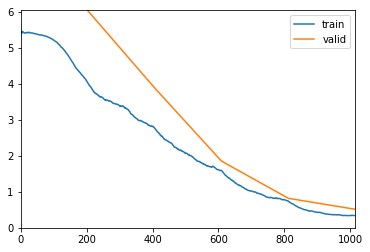

In [13]:
lr = 3e-3
wd = 1e-1
epochs = 5
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [14]:
learn.save("b3_squish_5epochs_delextraBN")

In [15]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.46624365, tensor(0.8618)]

# B3, Squish Resize, 10 Epochs

In [16]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [17]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [18]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0052,  0.0297,  0.0563,  ..., -0.0224,  0.0170, -0.0083],
        [ 0.0177, -0.0600, -0.0125,  ...,  0.0155, -0.0003, -0.0210],
        [-0.0525,  0.0239, -0.0498,  ..., -0.0483,  0.0444, -0.0162],
        ...,
        [-0.0220,  0.0069, -0.0109,  ...,  0.0083, -0.0175,  0.0059],
        [-0.0306,  0.0052,  0.0699,  ..., -0.0484,  0.0196, -0.0155],
        [ 0.0479,  0.0388,  0.0242,  ...,  0.0422,  0.0465, -0.0197]],
       requires_grad=True)


In [19]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Dodge Dakota Club Cab 2007,Dodge Journey SUV 2012,Dodge Charger Sedan 2012,Chevrolet Traverse SUV 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Toyota 4Runner SUV 2012,Ferrari 458 Italia Convertible 2012,Cadillac Escalade EXT Crew Cab 2007,Cadillac CTS-V Sedan 2012,Buick Regal GS 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3

epoch,train_loss,valid_loss,accuracy,time
0,4.606143,3.938150,0.133907,01:33
1,2.647028,4.802804,0.179975,01:33
2,2.177080,2.877943,0.311425,01:34
3,1.606682,3.091734,0.265971,01:33
4,1.179604,2.375498,0.432432,01:33
5,0.788048,1.457037,0.603194,01:33
6,0.482107,0.912161,0.754300,01:33
7,0.232403,0.583314,0.837838,01:33
8,0.136256,0.437136,0.874693,01:33
9,0.086852,0.421378,0.881450,01:32


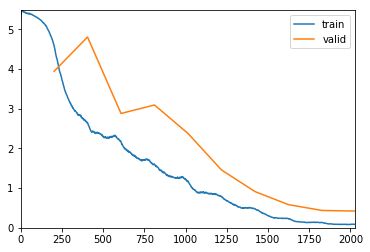

In [20]:
lr = 3e-3
wd = 1e-1
epochs = 10
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [21]:
learn.save("b3_squish_10epochs_delextraBN")

In [22]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.36836353, tensor(0.8988)]

# B3, Squish Resize, 20 Epochs

In [23]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [24]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [25]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0477,  0.0116, -0.0115,  ...,  0.0296,  0.0023, -0.0329],
        [ 0.0353, -0.0733, -0.0141,  ...,  0.0182, -0.0187,  0.0307],
        [ 0.0435, -0.0272, -0.0181,  ...,  0.0040,  0.0461,  0.0848],
        ...,
        [-0.0039,  0.0460,  0.0303,  ..., -0.0165, -0.0330, -0.0518],
        [-0.0143, -0.0255,  0.0056,  ..., -0.0273,  0.0061,  0.0093],
        [-0.0108,  0.0083,  0.0022,  ..., -0.0749,  0.0207, -0.0380]],
       requires_grad=True)


In [26]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Dodge Journey SUV 2012,Dodge Charger Sedan 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Ford Expedition EL SUV 2009,Hyundai Azera Sedan 2012,Jeep Wrangler SUV 2012,GMC Savana Van 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), stride=[1, 1], gr

epoch,train_loss,valid_loss,accuracy,time
0,4.998348,4.599803,0.093366,01:34
1,2.685622,1.964207,0.501229,01:33
2,1.663632,2.638872,0.402334,01:33
3,1.673813,2.670644,0.411548,01:33
4,1.524455,3.306524,0.331081,01:33
5,1.420306,2.972173,0.360565,01:33
6,1.207585,2.392275,0.422604,01:34
7,1.038747,1.943943,0.517813,01:33
8,0.918218,1.920231,0.524570,01:34
9,0.733144,1.758879,0.551597,01:34


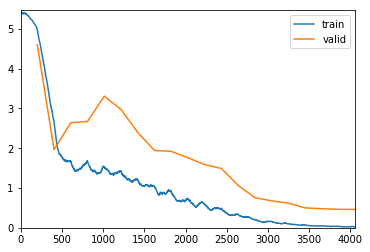

In [27]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [28]:
learn.save("b3_squish_20epochs_delextraBN")

In [29]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.38278568, tensor(0.9099)]

# B3, Squish Resize, 40 Epochs

In [30]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [72]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [73]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0236,  0.0427,  0.0382,  ..., -0.0184,  0.0693, -0.0091],
        [ 0.0148,  0.0055,  0.0404,  ..., -0.0035,  0.0616, -0.0192],
        [-0.0177,  0.0290, -0.0114,  ..., -0.0569,  0.0201,  0.0118],
        ...,
        [ 0.0604, -0.0160,  0.0609,  ..., -0.0144, -0.0334,  0.0391],
        [-0.0505, -0.0488, -0.0248,  ..., -0.0867, -0.0318,  0.0139],
        [-0.0135,  0.0413,  0.0100,  ..., -0.0285,  0.0018, -0.0007]],
       requires_grad=True)


In [74]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Suzuki Kizashi Sedan 2012,Chevrolet Sonic Sedan 2012,Buick Rainier SUV 2007,Audi S4 Sedan 2012,Jeep Wrangler SUV 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), strid

epoch,train_loss,valid_loss,accuracy,time
0,5.128613,4.861635,0.068182,01:34
1,3.683148,2.941810,0.360565,01:33
2,1.803190,1.429626,0.640049,01:34
3,1.031447,1.325484,0.636978,01:33
4,0.987477,1.734598,0.580467,01:33
5,1.047483,2.103171,0.508600,01:33
6,1.109118,1.809640,0.555897,01:34
7,1.138561,2.383320,0.442260,01:33
8,1.131836,2.695831,0.391278,01:34
9,1.159948,2.840493,0.400491,01:33


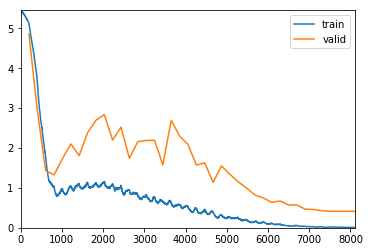

In [34]:
lr = 3e-3
wd = 1e-1
epochs = 40
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [75]:
# learn.save("b3_squish_40epochs_delextraBN")

In [76]:
learn.load("b3_squish_40epochs_delextraBN")

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Suzuki Kizashi Sedan 2012,Chevrolet Sonic Sedan 2012,Buick Rainier SUV 2007,Audi S4 Sedan 2012,Jeep Wrangler SUV 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), strid

In [77]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.39753482, tensor(0.9114)]

# B3, Squish Resize, 60 Epochs

In [37]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [38]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [39]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0191, -0.0069, -0.0193,  ..., -0.0038,  0.0247,  0.0120],
        [-0.0190, -0.0468, -0.0101,  ...,  0.0143, -0.0132, -0.0188],
        [-0.0589, -0.0107,  0.0006,  ...,  0.0211, -0.0241, -0.0263],
        ...,
        [ 0.0176, -0.0264,  0.0600,  ...,  0.0285,  0.0299,  0.0342],
        [-0.0176, -0.0185,  0.0985,  ...,  0.0777,  0.0076,  0.0430],
        [-0.0050, -0.0994, -0.0289,  ...,  0.0018,  0.0163, -0.0526]],
       requires_grad=True)


In [40]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Geo Metro Convertible 1993,Dodge Journey SUV 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Dodge Durango SUV 2012,GMC Yukon Hybrid SUV 2012,Cadillac CTS-V Sedan 2012,Chrysler Sebring Convertible 2010,BMW M3 Coupe 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), stride=[1

epoch,train_loss,valid_loss,accuracy,time
0,5.133954,4.896970,0.078624,01:33
1,4.021070,3.411146,0.310811,01:33
2,2.328663,1.715750,0.614251,01:33
3,1.176291,1.045913,0.740172,01:33
4,0.728208,0.983831,0.728501,01:33
5,0.652868,1.344279,0.652334,01:33
6,0.744472,1.498730,0.639435,01:33
7,0.833667,1.737340,0.594595,01:34
8,0.781198,1.676369,0.603808,01:33
9,0.810158,1.829392,0.593980,01:33


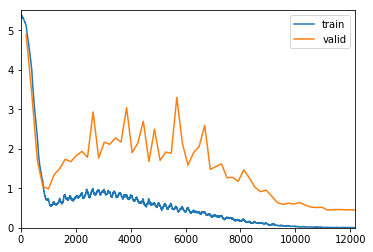

In [41]:
lr = 3e-3
wd = 1e-1
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [42]:
learn.save("b3_squish_60epochs_delextraBN")

In [43]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.46149084, tensor(0.9039)]

# B3, Squish Resize, 80 Epochs

In [44]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [45]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [46]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0528, -0.0006,  0.0088,  ..., -0.0220,  0.0292,  0.0340],
        [-0.0068, -0.0522, -0.0363,  ...,  0.0164, -0.0067,  0.0089],
        [ 0.0207, -0.0712, -0.0314,  ..., -0.0325, -0.0015, -0.0116],
        ...,
        [-0.0457, -0.0126,  0.0412,  ...,  0.0028,  0.0078,  0.0328],
        [ 0.0070,  0.0334, -0.0511,  ..., -0.0133, -0.0134,  0.0442],
        [-0.0337,  0.0558,  0.0454,  ...,  0.0514,  0.0118, -0.0756]],
       requires_grad=True)


In [47]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Ford Ranger SuperCab 2011,Isuzu Ascender SUV 2008,Nissan Juke Hatchback 2012,Ford F-150 Regular Cab 2007,Chevrolet Malibu Sedan 2007
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3),

epoch,train_loss,valid_loss,accuracy,time
0,5.152809,4.900450,0.078010,01:33
1,4.064227,3.467667,0.297297,01:33
2,2.548881,1.940120,0.601351,01:33
3,1.381855,1.138963,0.726658,01:34
4,0.766221,0.917035,0.759828,01:34
5,0.495663,0.895098,0.752457,01:33
6,0.461132,0.932477,0.744472,01:34
7,0.573592,1.271542,0.665848,01:33
8,0.582742,1.410255,0.664619,01:33
9,0.670396,1.604575,0.622236,01:33


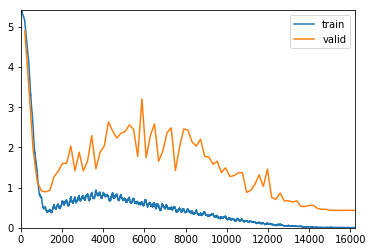

In [48]:
lr = 3e-3
wd = 1e-1
epochs = 80
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [49]:
learn.save("b3_squish_80epochs_delextraBN")

In [50]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.4805546, tensor(0.8992)]

# B3, Squish Resize, 40 Epochs, lr = 1e-2

In [51]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [52]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [53]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0239, -0.0177,  0.0071,  ...,  0.0104,  0.0427,  0.0418],
        [ 0.0114, -0.0531,  0.0295,  ...,  0.0074,  0.0542, -0.0335],
        [ 0.0402,  0.0255,  0.0226,  ..., -0.0102,  0.0198, -0.0280],
        ...,
        [ 0.0772,  0.0457,  0.0292,  ...,  0.0304, -0.0328,  0.0189],
        [ 0.0131,  0.0357, -0.0120,  ..., -0.0017, -0.0066, -0.0547],
        [-0.0423, -0.0165,  0.0178,  ..., -0.0440,  0.0151, -0.0741]],
       requires_grad=True)


In [54]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012,Geo Metro Convertible 1993,Dodge Journey SUV 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Dodge Ram Pickup 3500 Quad Cab 2009,Toyota Camry Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Mercedes-Benz E-Class Sedan 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40

epoch,train_loss,valid_loss,accuracy,time
0,4.150686,3.233071,0.257985,01:33
1,1.930309,1.783571,0.523342,01:33
2,1.542841,3.070554,0.357494,01:33
3,1.664267,3.180680,0.313882,01:33
4,1.837202,2.871533,0.321253,01:33
5,2.105239,4.499258,0.104423,01:33
6,2.230788,3.966949,0.164005,01:33
7,2.349035,5.836237,0.047297,01:33
8,2.433221,5.261829,0.064496,01:33
9,2.432935,5.841343,0.030713,01:33


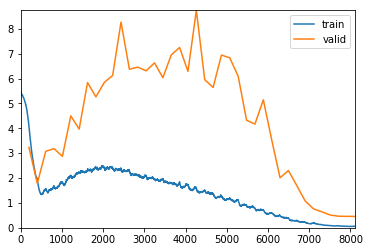

In [55]:
lr = 1e-2
wd = 1e-1
epochs = 40
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [56]:
learn.save("b3_squish_40epochs_delextraBN_lr1e-2")

In [57]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.45584378, tensor(0.8777)]

# B3, Squish Resize, 40 Epochs, lr = 1e-3

In [58]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [59]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [60]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0199,  0.0376,  0.0024,  ..., -0.0224, -0.0216,  0.0478],
        [-0.0051,  0.0227, -0.0222,  ...,  0.0029, -0.0075,  0.0368],
        [ 0.0533,  0.0496, -0.0542,  ...,  0.0442,  0.0206, -0.0109],
        ...,
        [-0.0150,  0.0203, -0.0239,  ...,  0.0131,  0.0330, -0.0460],
        [ 0.0706,  0.0174,  0.0312,  ..., -0.0285, -0.0359, -0.0253],
        [ 0.0132, -0.0506,  0.0547,  ...,  0.0034,  0.0494, -0.0249]],
       requires_grad=True)


In [61]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Daewoo Nubira Wagon 2002,Suzuki Aerio Sedan 2007,Cadillac Escalade EXT Crew Cab 2007,Chrysler Sebring Convertible 2010,Rolls-Royce Phantom Sedan 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePa

epoch,train_loss,valid_loss,accuracy,time
0,5.334305,5.216760,0.008600,01:33
1,5.036322,4.857697,0.084152,01:33
2,4.126465,3.599284,0.280713,01:33
3,2.580923,1.956789,0.579853,01:33
4,1.309401,1.159186,0.705774,01:33
5,0.725808,0.993882,0.722973,01:33
6,0.549538,1.022389,0.725430,01:33
7,0.553513,1.106877,0.709459,01:33
8,0.501554,1.408859,0.666462,01:33
9,0.518499,1.027107,0.733415,01:33


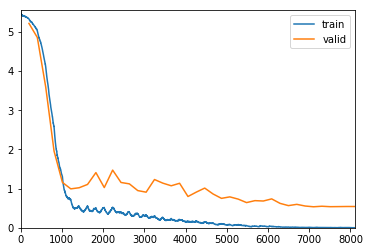

In [62]:
lr = 1e-3
wd = 1e-1
epochs = 40
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [63]:
learn.save("b3_squish_40epochs_delextraBN_lr1e-3")

In [64]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.5068277, tensor(0.9059)]

# B3, Squish Resize, 40 Epochs, lr = 3e-4

In [65]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [66]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

In [67]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0619,  0.0118,  0.0394,  ...,  0.0528, -0.0217,  0.0045],
        [-0.0109, -0.0185,  0.0061,  ...,  0.0224,  0.0183,  0.0421],
        [-0.0757,  0.0118, -0.0022,  ...,  0.0165,  0.0484, -0.0731],
        ...,
        [-0.0152, -0.0237, -0.0134,  ...,  0.0189, -0.0294,  0.0908],
        [-0.0811,  0.0209, -0.0265,  ...,  0.0463, -0.0048,  0.0106],
        [ 0.0372,  0.0302,  0.0257,  ..., -0.0519, -0.0107, -0.0106]],
       requires_grad=True)


In [68]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
HUMMER H3T Crew Cab 2010,Volkswagen Beetle Hatchback 2012,Ford Expedition EL SUV 2009,Rolls-Royce Ghost Sedan 2012,Rolls-Royce Ghost Sedan 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40,

epoch,train_loss,valid_loss,accuracy,time
0,5.389894,5.279595,0.004300,01:38
1,5.311106,5.209822,0.015356,01:37
2,5.163714,5.068162,0.042383,01:35
3,4.807583,4.623600,0.130835,01:35
4,4.044182,3.624057,0.281941,01:34
5,2.868596,2.445607,0.507371,01:34
6,1.792531,1.578334,0.663391,01:33
7,1.028901,1.043203,0.751843,01:35
8,0.600283,0.852224,0.769656,01:34
9,0.334568,0.754088,0.787469,01:35


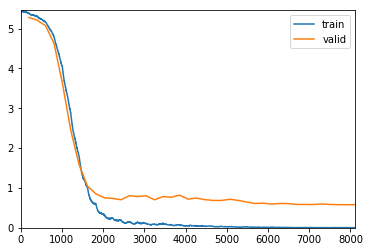

In [69]:
lr = 3e-4
wd = 1e-1
epochs = 40
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [70]:
learn.save("b3_squish_40epochs_delextraBN_lr3e-4")

In [71]:
learn.to_fp32().validate(img_data_test.train_dl)

[0.6200281, tensor(0.8810)]

# fin